In [1]:
import torch
from torch import nn
from torch.nn import functional as F


def dice_loss(input, target):
    EPS = 1e-15
    dice_target = (target == 1).float()
    dice_input = input
    
    intersection = (dice_target * dice_input).sum() + EPS
    union = dice_target.sum() + dice_input.sum() + EPS
    return 2.0 * intersection / union


class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        return dice_loss(input, target)


class BCEDiceLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.dice = DiceLoss()
        self.bce = nn.modules.loss.BCEWithLogitsLoss()

    def forward(self, input, target):
        return 0.5 * self.bce(input, target) - self.dice(input, target)


class BCEDiceLossMulti(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.bce_dice = BCEDiceLoss()
        self.num_classes = num_classes

    def forward(self, input, target):
        loss = 0
        for cls in range(self.num_classes):
            loss += self.bce_dice(input[:, cls], target[:, cls])
        return loss / self.num_classes


In [1]:
import torch
from torch import nn
from torch.nn import functional as F


def dice_loss(preds, trues, is_average=True):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)
    intersection = (preds * trues).sum(1)
    scores = 2.0 * (intersection + 1) / (preds.sum(1) + trues.sum(1) + 1)

    if is_average:
        score = scores.sum() / num
        return torch.clamp(score, 0., 1.)
    else:
        return scores


class DiceLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average
    
    def forward(self, input, target):
        return dice_loss(F.sigmoid(input), target, is_average=self.size_average)


class BCEDiceLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.dice = DiceLoss(size_average=size_average)
        self.bce = nn.modules.loss.BCEWithLogitsLoss(size_average=self.size_average)
    
    def forward(self, input, target):
        return 0.5 * self.bce(input, target) - self.dice(input, target)


class BCEDiceLossMulti(nn.Module):
    def __init__(self, size_average=True, num_classes=1):
        super().__init__()
        self.size_average = size_average
        self.bce_dice = BCEDiceLoss(size_average=size_average)
        self.num_classes = num_classes

    def forward(self, input, target):
        loss = 0
        for cls in range(self.num_classes):
            loss += self.bce_dice(input[:, cls].contiguous(), target[:, cls].contiguous())
        return loss / self.num_classes


In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

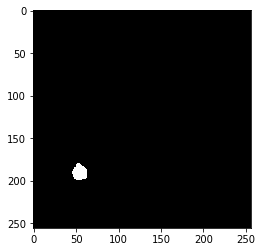

In [3]:
gt_mask = cv2.imread("../../dsbowl_old/data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png")
plt.imshow(gt_mask)

In [4]:
import sys
sys.path.append('../../dstorch/')

In [5]:
from dstorch import utils
import numpy as np

In [12]:
target = utils.to_float_tensor(gt_mask / 255).view(1, 3, 256, 256)
input =  torch.FloatTensor(1, 3, 256, 256).uniform_(0, 1)
BCEDiceLossMulti(num_classes=3).forward(utils.variable(input), utils.variable(target))

Variable containing:
 0.4836
[torch.FloatTensor of size 1]

In [13]:
target = utils.to_float_tensor(gt_mask[..., 0] / 255).view(1, 1, 256, 256)
input =  torch.FloatTensor(1, 1, 256, 256).uniform_(0, 1)
BCEDiceLoss().forward(utils.variable(input), utils.variable(target))

Variable containing:
 0.4839
[torch.FloatTensor of size 1]

In [213]:
target


( 0 , 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.FloatTensor of size 1x1x256x256]